# Setup

In [1]:
# import packages
%run ../../global_packages.py

# get the global parameters
%run ../../global_pars.py

# import your local functions
sys.path.insert(1, '../../')
from global_functions import *

# make sure the figures plot inline rather than at the end
%matplotlib inline

# Paths and Parameters

In [2]:
outfn = 'sla_to_wod.nc'

ds_out = xr.Dataset()

# Read Data

In [3]:
ds_SLA = xr.open_dataset('../2_SLA/sla_processed.nc')
ds_SLA

<xarray.Dataset>
Dimensions:           (day_time: 10013, lat: 138, loc_list: 6, lon: 216, month: 12, no_stations: 505, time: 329)
Coordinates:
  * lon               (lon) float64 48.62 48.88 49.12 ... 101.9 102.1 102.4
  * lat               (lat) float64 -1.375 -1.125 -0.875 ... 32.38 32.62 32.88
  * time              (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2020-05-01
  * day_time          (day_time) datetime64[ns] 1993-01-01 ... 2020-05-31
  * month             (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * no_stations       (no_stations) float64 1.0 2.0 3.0 ... 503.0 504.0 505.0
  * loc_list          (loc_list) int64 0 75 225 294 415 504
Data variables:
    daily_sla         (day_time, lat, lon) float64 ...
    mon_sla           (time, lat, lon) float64 ...
    mon_sla_mon_clim  (month, lat, lon) float64 ...
    mon_sla_mon_anom  (time, lat, lon) float64 ...
    sta_loninds       (no_stations) int64 ...
    sta_latinds       (no_stations) int64 ...
    sta_lon           (no_sta

In [4]:
ds_WOD = xr.open_dataset('../0_WOD/wod_processed.nc')
ds_WOD

<xarray.Dataset>
Dimensions:           (depth: 57, time: 319847)
Coordinates:
  * time              (time) datetime64[ns] 1948-03-10 1948-03-11 ... 2020-05-31
  * depth             (depth) int64 0 5 10 15 20 25 ... 1300 1350 1400 1450 1500
Data variables:
    temp              (time, depth) float64 ...
    sal               (time, depth) float64 ...
    doxy              (time, depth) float64 ...
    nitrate           (time, depth) float64 ...
    phosphate         (time, depth) float64 ...
    lat               (time) float32 ...
    lon               (time) float32 ...
    cast_id           (time) object ...
    temp_40_200       (time) float64 ...
    doxy_40_200       (time) float64 ...
    sal_40_200        (time) float64 ...
    nitrate_40_200    (time) float64 ...
    phosphate_40_200  (time) float64 ...
    temp_50_200       (time) float64 ...
    doxy_50_200       (time) float64 ...
    sal_50_200        (time) float64 ...
    nitrate_50_200    (time) float64 ...
    phosphate

In [5]:
ds_mask = xr.open_dataset('../1_WOD_Coastal/IO_coastal_mask.nc')
ds_mask

<xarray.Dataset>
Dimensions:    (latn: 138, latw: 138, loc_wod: 319847, lonn: 216, lonw: 216)
Coordinates:
  * latw       (latw) float64 -1.375 -1.125 -0.875 -0.625 ... 32.38 32.62 32.88
  * lonw       (lonw) float64 48.62 48.88 49.12 49.38 ... 101.9 102.1 102.4
  * latn       (latn) float64 -1.5 -1.25 -1.0 -0.75 ... 32.0 32.25 32.5 32.75
  * lonn       (lonn) float64 48.5 48.75 49.0 49.25 ... 101.5 101.8 102.0 102.2
  * loc_wod    (loc_wod) int64 0 1 2 3 4 ... 319842 319843 319844 319845 319846
Data variables:
    maskw      (latw, lonw) int64 ...
    maskn      (latn, lonn) float64 ...
    maskw_wod  (loc_wod) bool ...
    maskn_wod  (loc_wod) bool ...

# Regrid

In [6]:
# find unique time values of wod data
time_key = np.unique(ds_WOD.time)

# find all the days there are measurements
full_ind = np.full((ds_SLA.daily_sla.shape[0]),False)

for tt in range(time_key.shape[0]):
    ind = ds_SLA.daily_sla.day_time == time_key[tt]
    full_ind = full_ind + ind

# take only times where awg measurements were made
sla = np.array(ds_SLA.daily_sla[full_ind,:,:])
sla_time = np.array(ds_SLA.daily_sla.day_time[full_ind])

xx,yy = np.meshgrid(ds_SLA.lon,ds_SLA.lat)
xx = xx.flatten()
yy = yy.flatten()

lons= np.array(ds_WOD.lon)
lats = np.array(ds_WOD.lat)
times = np.array(ds_WOD.time)

daily_sla_WOD = np.zeros(len(times))*np.nan
lon_WOD = np.zeros(len(times))*np.nan
lat_WOD = np.zeros(len(times))*np.nan
time_WOD = np.array(ds_WOD.time)

for tt in tqdm(range(sla.shape[0])):
    
    sla_tmp = np.array(sla[tt,:,:])
    indq = times == sla_time[tt]
    lonq = lons[indq]
    latq = lats[indq]

    # find the lons and lats of TCD vals at this time

    points = np.array( (xx,yy) ).T
    values = sla_tmp.flatten()


    daily_sla_WOD[indq] = griddata(points, values, (lonq,latq) ,method='linear' )
    lon_WOD[indq] = lonq
    lat_WOD[indq] = latq



100%|██████████| 9682/9682 [1:09:27<00:00,  2.40it/s]


In [7]:
# add variables to dataset

# WOD
ds_out["daily_sla"]=xr.DataArray(daily_sla_WOD,dims = ['time'],
                     coords =[time_WOD])
ds_out["lon"]=xr.DataArray(lon_WOD,dims = ['time'],
                     coords =[time_WOD])
ds_out["lat"]=xr.DataArray(lat_WOD,dims = ['time'],
                     coords =[time_WOD])

# Convert to Coastal

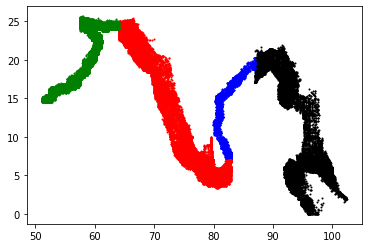

In [8]:
#############################################################
#----------------- Western Arabian Sea ---------------------#
#############################################################

ind_wAS = ((ds_WOD.lon <= bounds_wAS[1]) & (ds_WOD.lon >= bounds_wAS[0]) & 
              (ds_WOD.lat <= bounds_wAS[3]) & (ds_WOD.lat >= bounds_wAS[2]))

#subset gridded data
sla_wAS = ds_out.daily_sla[ind_wAS]
lat_wAS = ds_WOD.lat[ind_wAS]
lon_wAS = ds_WOD.lon[ind_wAS]
time_wAS = ds_WOD.time[ind_wAS]
mask_wAS = np.array(ds_mask.maskn_wod)[ind_wAS]
    
# convert to coastal
sla_wAS = sla_wAS[mask_wAS]
lat_wAS = lat_wAS[mask_wAS]
lon_wAS = lon_wAS[mask_wAS]
time_wAS = time_wAS[mask_wAS]

#############################################################
#----------------- Eastern Arabian Sea ---------------------#
#############################################################

ind_eAS = ((ds_WOD.lon <= bounds_eAS[1]) & (ds_WOD.lon >= bounds_eAS[0]) & 
              (ds_WOD.lat <= bounds_eAS[3]) & (ds_WOD.lat >= bounds_eAS[2])) 
ind_eAS_SL = ((ds_WOD.lon < bounds_eAS_SL[1]) & (ds_WOD.lon > bounds_eAS_SL[0]) & 
              (ds_WOD.lat < bounds_eAS_SL[3]) & (ds_WOD.lat > bounds_eAS_SL[2])) 

#subset gridded data
sla_eAS = xr.concat((ds_out.daily_sla[ind_eAS],ds_out.daily_sla[ind_eAS_SL]), dim = 'time')
lat_eAS = xr.concat((ds_WOD.lat[ind_eAS],ds_WOD.lat[ind_eAS_SL]), dim = 'time')
lon_eAS = xr.concat((ds_WOD.lon[ind_eAS],ds_WOD.lon[ind_eAS_SL]), dim = 'time')
time_eAS = sla_eAS.time
mask_eAS = np.array(ds_mask.maskw_wod)
mask_eAS = np.concatenate((mask_eAS[ind_eAS],mask_eAS[ind_eAS_SL]),0)

# convert to coastal
sla_eAS = sla_eAS[mask_eAS]
lat_eAS = lat_eAS[mask_eAS]
lon_eAS = lon_eAS[mask_eAS]
time_eAS = time_eAS[mask_eAS]

# sort by time
sla_eAS = sla_eAS.sortby(time_eAS)
lat_eAS = lat_eAS.sortby(time_eAS)
lon_eAS = lon_eAS.sortby(time_eAS)
time_eAS = time_eAS.sortby(time_eAS)

#############################################################
#---------------- Western Bay of Bengal --------------------#
#############################################################

ind_wBoB = ((ds_WOD.lon <= bounds_wBoB[1]) & (ds_WOD.lon >= bounds_wBoB[0]) & 
               (ds_WOD.lat <= bounds_wBoB[3]) & (ds_WOD.lat >= bounds_wBoB[2])) 
ind_wBoB_SL = ((ds_WOD.lon < bounds_wBoB_SL[1]) & (ds_WOD.lon > bounds_wBoB_SL[0]) & 
              (ds_WOD.lat < bounds_wBoB_SL[3]) & (ds_WOD.lat > bounds_wBoB_SL[2])) 

#subset gridded data
sla_wBoB = xr.concat((ds_out.daily_sla[ind_wBoB],ds_out.daily_sla[ind_wBoB_SL]), dim = 'time')
lat_wBoB = xr.concat((ds_WOD.lat[ind_wBoB],ds_WOD.lat[ind_wBoB_SL]), dim = 'time')
lon_wBoB = xr.concat((ds_WOD.lon[ind_wBoB],ds_WOD.lon[ind_wBoB_SL]), dim = 'time')
time_wBoB = sla_wBoB.time
mask_wBoB = np.array(ds_mask.maskn_wod)
mask_wBoB = np.concatenate((mask_wBoB[ind_wBoB],mask_wBoB[ind_wBoB_SL]),0)
    
# convert to coastal
sla_wBoB = sla_wBoB[mask_wBoB]
lat_wBoB = lat_wBoB[mask_wBoB]
lon_wBoB = lon_wBoB[mask_wBoB]
time_wBoB = time_wBoB[mask_wBoB]

# sort by time
sla_wBoB = sla_wBoB.sortby(time_wBoB)
lat_wBoB = lat_wBoB.sortby(time_wBoB)
lon_wBoB = lon_wBoB.sortby(time_wBoB)
time_wBoB = time_wBoB.sortby(time_wBoB)

#############################################################
#---------------- Eastern Bay of Bengal --------------------#
#############################################################

ind_eBoB = ((ds_WOD.lon <= bounds_eBoB[1]) & (ds_WOD.lon >= bounds_eBoB[0]) & 
               (ds_WOD.lat <= bounds_eBoB[3]) & (ds_WOD.lat >= bounds_eBoB[2])) 

#subset gridded data
sla_eBoB = ds_out.daily_sla[ind_eBoB]
lat_eBoB = ds_WOD.lat[ind_eBoB]
lon_eBoB = ds_WOD.lon[ind_eBoB]
time_eBoB = ds_WOD.time[ind_eBoB]
mask_eBoB = np.array(ds_mask.maskw_wod)[ind_eBoB]

# convert to coastal
sla_eBoB = sla_eBoB[mask_eBoB]
lat_eBoB = lat_eBoB[mask_eBoB]
lon_eBoB = lon_eBoB[mask_eBoB]
time_eBoB = time_eBoB[mask_eBoB]

plt.scatter(lon_eBoB,lat_eBoB,color = 'k', s = 1)
plt.scatter(lon_wBoB,lat_wBoB,color = 'b', s = 1)
plt.scatter(lon_eAS,lat_eAS,color = 'r', s = 1)
plt.scatter(lon_wAS,lat_wAS,color = 'g', s = 1)

#############################################################
#---------------------- Save Data --------------------------#
#############################################################
ds_out['lat_wAS'] = xr.DataArray(lat_wAS,dims = ['time_wAS'],coords =[time_wAS])
ds_out['lon_wAS'] = xr.DataArray(lon_wAS,dims = ['time_wAS'],coords =[time_wAS])
ds_out['lat_eAS'] = xr.DataArray(lat_eAS,dims = ['time_eAS'],coords =[time_eAS])
ds_out['lon_eAS'] = xr.DataArray(lon_eAS,dims = ['time_eAS'],coords =[time_eAS])
ds_out['lat_wBoB'] = xr.DataArray(lat_wBoB,dims = ['time_wBoB'],coords =[time_wBoB])
ds_out['lon_wBoB'] = xr.DataArray(lon_wBoB,dims = ['time_wBoB'],coords =[time_wBoB])
ds_out['lat_eBoB'] = xr.DataArray(lat_eBoB,dims = ['time_eBoB'],coords =[time_eBoB])
ds_out['lon_eBoB'] = xr.DataArray(lon_eBoB,dims = ['time_eBoB'],coords =[time_eBoB])

# Western Arabian Sea
ds_out['sla_wAS'] = xr.DataArray(sla_wAS,dims = ['time_wAS'],coords =[time_wAS])

# Eastern Arabian Sea
ds_out['sla_eAS'] = xr.DataArray(sla_eAS,dims = ['time_eAS'],coords =[time_eAS])

# Western Bay of Bengal
ds_out['sla_wBoB'] = xr.DataArray(sla_wBoB,dims = ['time_wBoB'],coords =[time_wBoB])

# Eastern Bay of Bengal
ds_out['sla_eBoB'] = xr.DataArray(sla_eBoB,dims = ['time_eBoB'],coords =[time_eBoB])



In [9]:
# delete if already present
if os.path.isfile(outfn):
    os.remove(outfn)

ds_out.to_netcdf(outfn,mode='w',format = "NETCDF4")

ds_out

<xarray.Dataset>
Dimensions:    (time: 319847, time_eAS: 23134, time_eBoB: 20710, time_wAS: 31230, time_wBoB: 2847)
Coordinates:
  * time       (time) datetime64[ns] 1948-03-10 1948-03-11 ... 2020-05-31
  * time_wAS   (time_wAS) datetime64[ns] 1948-06-12 1948-06-12 ... 2020-05-23
  * time_eAS   (time_eAS) datetime64[ns] 1948-03-14 1948-06-26 ... 2020-05-31
  * time_wBoB  (time_wBoB) datetime64[ns] 1951-04-20 1951-04-24 ... 2020-05-28
  * time_eBoB  (time_eBoB) datetime64[ns] 1948-06-29 1948-06-29 ... 2020-05-29
Data variables:
    daily_sla  (time) float64 nan nan nan nan ... 0.06474 0.05062 0.217 0.1077
    lon        (time) float64 nan nan nan nan nan ... 89.98 60.41 57.72 67.64
    lat        (time) float64 nan nan nan nan nan ... 3.584 0.153 15.84 13.86
    lat_wAS    (time_wAS) float32 22.3 23.116667 23.85 ... 16.498 16.702 16.689
    lon_wAS    (time_wAS) float32 60.666668 59.75 58.9 ... 53.946 54.473 54.967
    lat_eAS    (time_eAS) float32 4.6 8.283334 8.0 ... 20.875845 15.705
